In [2]:
#get dataframe of tweet_id and user_id
import pandas
import csv

df = pandas.read_csv('gamergate_tweets.csv')

In [3]:
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages")

from twython import Twython

#get first 5000 tweet_ids
CONSUMER_KEY = "48r56upQvsnTiSDfY4CNwIpCQ"
CONSUMER_SECRET = "VqZhFW7GqogdKXJnpuS0umVe211bFgoCdaQlRdRMayvrbdDh3k"
OAUTH_TOKEN = "18000528-Scl8a1pLinqP4KWtaa3f8EN0M1vqAGTyYXMtsLIGm"
OAUTH_TOKEN_SECRET = "NcIvLeqVbwwBegabvo7946FVIaDN0CAaJ7aS2aV7pZFzC"

twitter = Twython(
    CONSUMER_KEY, CONSUMER_SECRET,
    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)


start = 0
end = 100
tweet_list = []
while end <= 5000:
    id_list = df["tweet_id"].tolist()
    current = id_list[start:end]
    tweet = twitter.lookup_status(id=current)
    start += 100
    end += 100
    for t in tweet:
        each_tweet = []
        each_tweet.append(t['user']['id'])
        each_tweet.append(t["retweet_count"])
        each_tweet.append(t["favorite_count"])
        if t["entities"]['urls'] != []:
            each_tweet.append(1)
        else: each_tweet.append(0)
        if t["entities"]["user_mentions"] == []:
            each_tweet.append([])
        else: 
            y = 0
            mentionlist = []
            while y < len(t["entities"]["user_mentions"]):
                mentionlist.append((t["entities"]["user_mentions"])[y].items()[2][1])
                y+=1
            each_tweet.append(mentionlist)
        each_tweet.append(t["text"])
        tweet_list.append(each_tweet)

In [4]:
#put into df    
tweets_df = pandas.DataFrame(tweet_list, columns=["User ID", "Retweets", "Favorites", "Has_url", "Mentions", "Text"])

In [5]:
#use lexicon to get polarity of each tweet

#read and put positive words into list
with open('positive-words.txt') as f:
    positive = f.read().splitlines()
#trim list    
positive = positive[35:]
positive = set(positive)

#read and put negative words into list
with open('negative-words.txt') as f:
    negative = f.read().splitlines()
#trim list    
negative = negative[35:]
#remove problematic "naive"
negative.remove(negative[3007])
negative = set(negative)
    
lexrating = []
poscount = 0
negcount = 0

x = 0

for tweet in tweets_df["Text"]:
    words = tweet.split()
    for word in words:
        if word in positive:
            poscount = poscount + 1
        elif word in negative:
            negcount = negcount + 1
            
    #get polarity of tweet
    if negcount == 0: ratio = poscount
    elif poscount == 0: ratio = negcount * -1
    else : 
        if poscount > negcount: ratio = poscount - negcount
        else: ratio = (negcount - poscount) * -1
    
    lexrating.append(ratio)

    poscount = 0
    negcount = 0
    x += 1
        
    #add column of lexrating reviews
    tweets_df["Polarity"] = pandas.Series(lexrating)
    

polaritylist = tweets_df["Polarity"].tolist()
likelist = tweets_df["Favorites"].tolist()
retweetlist = tweets_df["Retweets"].tolist()

#Create Popularity column, where popularity = num(Retweets) + num(Favorites)
x = 0
popularity = []
while x < len(likelist):
    popularity.append(likelist[x] + retweetlist[x])
    x+=1

tweets_df["Popularity"] = pandas.Series(popularity)

print tweets_df
    

         User ID  Retweets  Favorites  Has_url  \
0       20708129       363          0        0   
1       20945241         1          0        0   
2      251045973         0          0        0   
3     1091189214         1          0        0   
4     2847688135         0          0        1   
5     2798609018         0          0        0   
6     2492324996       794          0        1   
7       93363347       238          0        1   
8      937178150        27          0        0   
9       36790442         0          0        1   
10    2590712055        33          0        1   
11      16326705       970          0        0   
12     985889652        80          0        1   
13      18746944       238          0        1   
14     162572003         0          1        0   
15     940132086       229          0        0   
16      49534986        19          0        0   
17     171848975         0          0        0   
18      49724410         0          0        0   


In [39]:
tweets_df = tweets_df.sort_values("Polarity")
pop = tweets_df["Popularity"].tolist()
hasurl = tweets_df["Has_url"].tolist()
mentions = tweets_df["Mentions"].tolist()
pol = tweets_df["Polarity"].tolist()

nummentions = []
for x in mentions:
    nummentions.append(len(x))

pol_labels = []    
for x in pol:
    if x not in pol_labels:
        pol_labels.append(x)
        
#get count for has_mentions or has_no_mentions
hascount = 0
nothascount = 0
count = 0
mentionhascount = []
mentionnothascount = []
current = pol[0]
for x in pol:
    if x == current:
        if mentions[count] == []:
            nothascount+=1
        else:
            hascount+=1
    else:
        mentionhascount.append(hascount)
        mentionnothascount.append(nothascount)
        hascount = 0
        nothascount = 0
    count+=1 
    current = x
    
mentionhascount.append(hascount)
mentionnothascount.append(nothascount)

#get count for has_url and not has_url
hascount = 0
nothascount = 0
count = 0
urlhascount = []
urlnothascount = []
current = pol[0]
for x in pol:
    if x == current:
        if hasurl[count] == 0:
            nothascount+=1
        else:
            hascount+=1
    else:
        urlhascount.append(hascount)
        urlnothascount.append(nothascount)
        hascount = 0
        nothascount = 0
    count+=1 
    current = x
    
urlhascount.append(hascount)
urlnothascount.append(nothascount)
    
x = 0
poplist = []
hasurllist = []
pollist = []
mentionlist = []
while x < len(pop):
    hasurllist.append(hasurl[x])
    poplist.append(pop[x])
    pollist.append(abs(pol[x])) 
    mentionlist.append(nummentions[x])
    x+=1

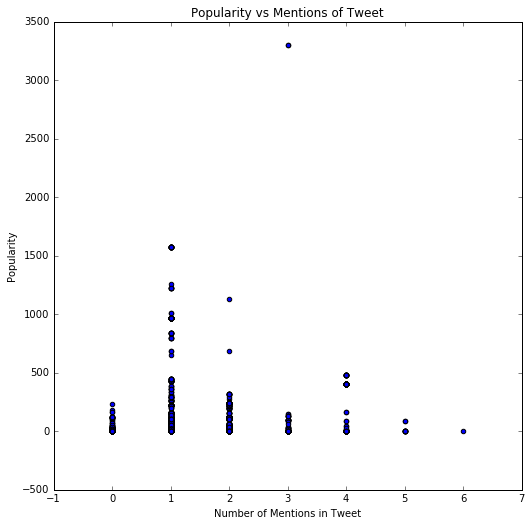

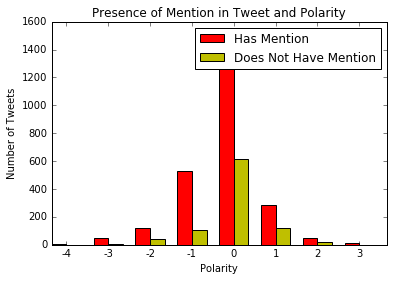

In [45]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pylab
import numpy as np

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]

plt.figure(1, figsize=(10, 10))

axScatter = plt.axes(rect_scatter)

axScatter.scatter(nummentions, pop)

plt.ylabel("Popularity")
plt.xlabel("Number of Mentions in Tweet")
plt.title("Popularity vs Mentions of Tweet")

plt.show()

import collections

counter=collections.Counter(nummentions)

x=0
mentions_counter = ()
while x < len(counter):
    mentions_counter += (counter[x],)
    x+=1
mentions_labels = ('0', '1', '2', '3', '4', '5', '6')

counter=collections.Counter(pol)

x=0
pol_counter = []
space = 1
for x in counter.items():
    if x[0] < 0 and len(pol_counter) > abs(x[0]):
        pol_counter[abs(x[0])] += x[1]
        space+=1
    else: 
        pol_counter.append(x[1])

#add zeros
while len(pol_counter) < len(mentions_labels):
    pol_counter.append(0)

pol_counter = tuple(pol_counter)  

#plot
N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, mentionhascount, width, color='r')

rects2 = ax.bar(ind + width, mentionnothascount, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Polarity')
ax.set_title('Presence of Mention in Tweet and Polarity')
ax.set_xticks(ind + width)
ax.set_xticklabels(pol_labels)

ax.legend((rects1[0], rects2[0]), ('Has Mention', 'Does Not Have Mention'))


plt.show()

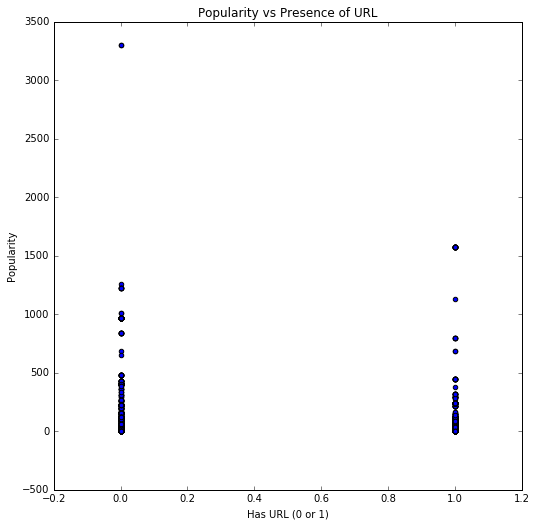

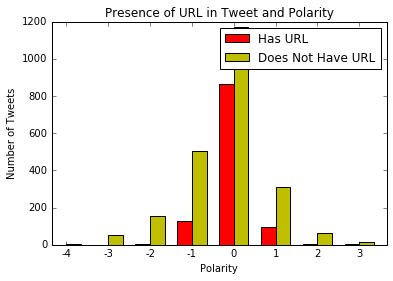

In [38]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]

plt.figure(1, figsize=(10, 10))

axScatter = plt.axes(rect_scatter)

axScatter.scatter(hasurllist, pop)

plt.ylabel("Popularity")
plt.xlabel("Has URL (0 or 1)")
plt.title("Popularity vs Presence of URL")

plt.show()


#plot
N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, tuple(urlhascount), width, color='r')

rects2 = ax.bar(ind + width, tuple(urlnothascount), width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Polarity')
ax.set_title('Presence of URL in Tweet and Polarity')
ax.set_xticks(ind + width)
ax.set_xticklabels(pol_labels)

ax.legend((rects1[0], rects2[0]), ('Has URL', 'Does Not Have URL'))


plt.show()

